In [4]:
import pandas as pd
import numpy as np
import re
import string

#import dataset
data = pd.read_csv("RateMyProfessor_Sample data.csv", usecols = ["comments", "student_star"])

#preprocessing
#remove all punctuation
data["comments"] = data["comments"].str.replace(r'[^\w\s]+', '', regex = True)
#make all letters lowercase
data["comments"] = data["comments"].str.lower()
#split each word (removed)
#data["comments"] = data["comments"].str.split()

#alter target attribute: any score 3.4 or above is considered a positive review
data['student_star'] = data['student_star'].where(data['student_star'] > 3.4, -1)
data['student_star'] = data['student_star'].where(data['student_star'] <= 3.4, 1)

X = data.iloc[:, -1]
y = data.iloc[:, :-1]

print(data)

       student_star                                           comments
0               1.0  this class is hard but its a twoinone gened kn...
1               1.0  definitely going to choose prof looneys class ...
2               1.0  i overall enjoyed this class because the assig...
3               1.0  yes its possible to get an a but youll definit...
4               1.0  professor looney has great knowledge in astron...
...             ...                                                ...
19995          -1.0            great sense of humor love parasites now
19996          -1.0  he is a really nice guy and is really funnyhow...
19997           1.0  his parasitology class is a lot of work but he...
19998           1.0  he is way too much work for a 1 credit class s...
19999           1.0  extremely easy lab teacher quizzes are a littl...

[20000 rows x 2 columns]


In [97]:
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#list of stop words
stop_str = (['the', 'a', 'and', 'to', 'you', 'is', 'class', 'he', 'she', 'of', 'an', 'in',
            'but', 'his', 'her', 'was', 'have', 'with', 'take', 'with', 'that', 'do', 'be',
            'for', 'if', 'it', 'are', 'on', 'this', 'will', 'at', 'about', 'as', 'so', 'guy',
            'him', 'your', 'had', 'can', 'hes', 'from', 'me', 'its', 'shes', 'get', 'my'])

cv = CountVectorizer(stop_words = stop_str)
tfidf_transformer = TfidfTransformer()


#bag of words
X_bow = cv.fit_transform(X.values.astype('U'))
X_bow.shape

(20000, 19924)

There are 20000 total records.
There are 12932 positive records.
There are 7068 negative records.
64.66% of records in the dataset are positive.



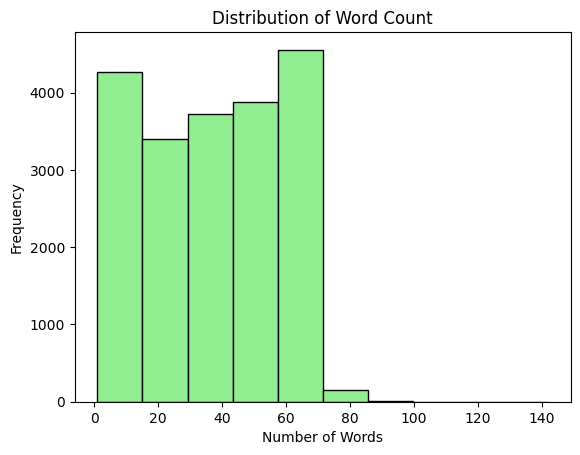


There are 19924 unique words.

The 25 most common words, excluding stop words, are: 
[('very', 7368), ('not', 6357), ('teacher', 4005), ('professor', 3859), ('easy', 3464), ('great', 3382), ('really', 3358), ('all', 3175), ('good', 3002), ('students', 2656), ('no', 2633), ('hard', 2601), ('what', 2549), ('tests', 2523), ('dont', 2300), ('one', 2257), ('just', 2219), ('work', 2155), ('lot', 2099), ('help', 2015), ('best', 1948), ('like', 1905), ('time', 1885), ('lectures', 1784), ('would', 1764)]


In [165]:
#analysis of dataset
#class distribution, text length distribution, total unique words, most common words
import matplotlib.pyplot as plt

#print('The accuracy for Naive Bayes classifier using TF-IDF is {:.5f} on training data'.format(accuracy_score(y_pred = clf.predict(X_train), y_true = y_train)))
pos_ct = sum(data['student_star'] > 0)
neg_ct = sum(data['student_star'] < 0)

print('There are {:.0f} total records.'.format( pos_ct + neg_ct ))
print('There are {:.0f} positive records.'.format( pos_ct ))
print('There are {:.0f} negative records.'.format( neg_ct ))
print('{:.2f}% of records in the dataset are positive.\n'.format( (pos_ct / (pos_ct + neg_ct)) * 100 ))

word_ct = pd.read_csv("RateMyProfessor_Sample data.csv", usecols = ["word_comment"])
plt.hist(word_ct, color='lightgreen', ec='black', bins=10)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Word Count")
plt.show()

print('\nThere are {:.0f} unique words.\n'.format( len(cv.get_feature_names_out()) ))

print('The 25 most common words, excluding stop words, are: ')
freqs = zip(cv.get_feature_names_out(), X_bow.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print( sorted(freqs, key=lambda x: -x[1]) [:25]) 

In [166]:
#training classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#train-test split with Bag of Words, then apply TF-IDF to have same set of sample data
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size = 0.2)

y_train_arr = y_train.to_numpy().reshape(-1)

X_tfidf_train = tfidf_transformer.fit_transform(X_bow_train)
X_tfidf_train.shape
X_tfidf_test = tfidf_transformer.fit_transform(X_bow_test)
X_tfidf_test.shape

print('Classifier\t Extr.\t\t Train Acc.\t Test Acc.')
print('---------------------------------------------------------')

#naive bayes
from sklearn.naive_bayes import MultinomialNB
clf_bow = MultinomialNB().fit(X_bow_train, y_train_arr)
clf_tfidf = MultinomialNB().fit(X_tfidf_train, y_train_arr)
print('Naive Bayes\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = clf_bow.predict(X_bow_train), y_true = y_train),
                                                              accuracy_score(y_pred = clf_bow.predict(X_bow_test), y_true = y_test)))
print('Naive Bayes\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = clf_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                                 accuracy_score(y_pred = clf_tfidf.predict(X_tfidf_test), y_true = y_test)))


print('---------------------------------------------------------')
#support vector machine
from sklearn.linear_model import SGDClassifier
svm_bow = SGDClassifier().fit(X_bow_train, y_train_arr)
svm_tfidf = SGDClassifier().fit(X_tfidf_train, y_train_arr)
print('SVM\t\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svm_bow.predict(X_bow_train), y_true = y_train),
                                                          accuracy_score(y_pred = svm_bow.predict(X_bow_test), y_true = y_test)))
print('SVM\t\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svm_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                             accuracy_score(y_pred = svm_tfidf.predict(X_tfidf_test), y_true = y_test)))


print('---------------------------------------------------------')
#logistic regression
from sklearn.linear_model import LogisticRegression
lr_bow = LogisticRegression().fit(X_bow_train, y_train_arr)
lr_tfidf = LogisticRegression().fit(X_tfidf_train, y_train_arr)
print('Log Regression\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = lr_bow.predict(X_bow_train), y_true = y_train),
                                               accuracy_score(y_pred = lr_bow.predict(X_bow_test), y_true = y_test)))
print('Log Regression\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = lr_tfidf.predict(X_tfidf_train), y_true = y_train),
                                               accuracy_score(y_pred = lr_bow.predict(X_tfidf_test), y_true = y_test)))

print('---------------------------------------------------------')
#linear support vector classification
from sklearn.svm import LinearSVC
svc_bow = LinearSVC(max_iter = 2000).fit(X_bow_train, y_train_arr)
svc_tfidf = LinearSVC().fit(X_tfidf_train, y_train_arr)
print('SVC\t\t BoW\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svc_bow.predict(X_bow_train), y_true = y_train),
                                               accuracy_score(y_pred = svc_bow.predict(X_bow_test), y_true = y_test)))
print('SVC\t\t TF-IDF\t\t {:.5f}\t {:.5f}'.format(accuracy_score(y_pred = svc_tfidf.predict(X_tfidf_train), y_true = y_train),
                                                  accuracy_score(y_pred = svc_tfidf.predict(X_tfidf_test), y_true = y_test)))



Classifier	 Extr.		 Train Acc.	 Test Acc.
---------------------------------------------------------
Naive Bayes	 BoW		 0.88000	 0.82950
Naive Bayes	 TF-IDF		 0.80725	 0.75750
---------------------------------------------------------
SVM		 BoW		 0.93663	 0.82125
SVM		 TF-IDF		 0.89263	 0.83875
---------------------------------------------------------
Log Regression	 BoW		 0.92519	 0.83600
Log Regression	 TF-IDF		 0.88125	 0.81650
---------------------------------------------------------
SVC		 BoW		 0.96100	 0.80650
SVC		 TF-IDF		 0.93656	 0.83000
